<a href="https://colab.research.google.com/github/DevanWestley/AI_CourseDEIE/blob/main/Transformer_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Week 14: Building Transformer with Attention**

#### Compiled by Devan Westley
**Diclaimer:** <br/> This modul is part of hands on supplement for "Artificial Intelligence" course in The Department of Electrical and Information Engineering, Faculty of Engineering, Universitas Gadjah Mada, Indonesia. All codes are for solely educational purposes to explain lecture materials and provide deeper understanding on the presented materials. The codes are modified version of [a tutorial by Adrian Tam](https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/).

### Table of interest:
1. Obtaining the data and performing normalization
2. Observing statistics of the dataset
3. Vectorization
4. Positional encoding
5. Self-attention model of encoder
6. Cross-attention model of decoder
7. Feed forward network
8. Transformer encoder and decoder
9. Training preparation
10. Training the Transformer model
11. Inference


Transformer is a recent breakthrough in neural machine translation. Natural languages are complicated. A word in one language can be translated into multiple words in another, **depending on the context of the sentence**. But what exactly a context is, and how you can teach the computer to understand the context was a big problem to solve.

The invention of the attention mechanism solved the problem of how to encode a context into a word, or in other words, how you can present a word and its context together in a numerical vector. Transformer brings this to one level higher so that we can build a neural network for natural language translation using only the attention mechanism but no recurrent structure. This not only makes the network simpler, easier to train, and parallelizable in algorithm but also allows a more complicated language model to be built. As a result, we can see computer-translated sentences almost flawlessly.

Such a powerful deep learning model is not difficult to build. In TensorFlow and Keras, you have almost all the building blocks readily available. It is fun to see a Transformer model built and trained. It is even more fun to see a trained model to translate sentences from one language to another.

In this crash course, you will build a Transformer model in the similar design as the original research paper.

**Note (Dr. Sunu Wibirama):** <br/>
I trained the model in this tutorial using A100 GPU in Google Colab Pro. You might want to switch your setting to GPU as well if you use free version of Google Colab.

## Step 1: Obtaining the data and performing normalization

Let’s build a sentence-based English-to-French translator. There are many resources on the Internet. An example would be the user-contributed data for the flash card app Anki. You can download some data files at https://ankiweb.net/shared/decks/french. The data file would be a ZIP file containing a SQLite database file, from which you can extract the English-French sentence pairs.

However, you may find it more convenient to have a text file version, which you can find it at https://www.manythings.org/anki/. Google hosts a mirror of this file as
well, which we will be using.

Just like all NLP tasks, you need to normalize the text before you use it. French letters have accents which would be represented as Unicode characters, but such representation is not unique in Unicode. Therefore, you will convert the string into NFKC (compatibility and composition normal form).

Next, you will tokenize the sentences. Each word should be a separate token as well as each punctuation mark. However, the punctuation used in contractions such as don’t, va-t-il, or c’est are not separated from the words. Also, convert everything into lowercase in the expectation that this will reduce the number of distinct words in the vocabulary.

Normalization and tokenization can go a lot deeper, such as subword tokenization, stemming, and lemmatization. But to keep things simple, you do not do these in this project.

Starting from scratch, the code to normalize the text is below. You will use the Python module unicodedata to convert a Unicode string into NFKC normal form. Then you will use regular expression to add space around punctuation marks.

Afterward, you will wrap the French sentences (i.e., the target language) with sentinels [start] and [end]. You will see the purpose of the sentinels in later lessons.


In [ ]:
#!pip install tensorflow==2.15

In [ ]:
import pathlib
import pickle
import random
import re
import unicodedata
import numpy as np

import tensorflow as tf

# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)

def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra

# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

3423204/3423204 [==============================] - 0s 0us/step
/root/.keras/datasets/fra.txt
('every season is different .', '[start] chaque saison est différente . [end]')
('i want you to speak frankly .', '[start] je veux que tu parles franchement . [end]')
('tom said you were in boston .', '[start] tom a dit que vous étiez à boston . [end]')
('she got married to him .', "[start] elle l'épousa . [end]")
('i have no idea why it is so .', "[start] je n'ai aucune idée pourquoi il en est ainsi . [end]")


## Step 2: Observing statistics of the dataset

When you use it for your model, you want to know some statistics about this dataset. In particular, you want to see how many distinct tokens (words) in each language and how long the sentences are. Besides, knowing the maximum length of sentences is not as useful as knowing their distribution. You should plot a histogram for that.

Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs


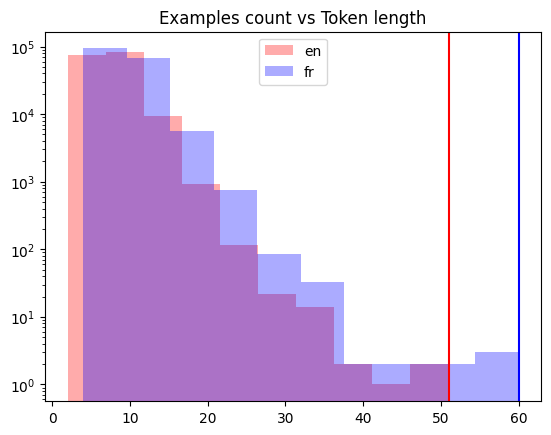

In [ ]:
import pickle
import matplotlib.pyplot as plt

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

## Step 3: Vectorization

 Neural networks can handle only numbers. One way to convert the text into numbers is through vectorization. What this means is to transform the tokens from the text into an integer. Hence a sentence with $n$
 tokens (words) will become a vector of $n$
 integers.

You can build your own vectorizer. **Simply build a mapping table of each unique token to a unique integer**. When it is used, you look up the token one by one in the table and return the integers in the form of a vector.

In Keras, you have `TextVectorization` layer to save us the effort of building a vectorizer. It supports padding, i.e., integer 0 is reserved to mean “empty.” This is useful when you give a sentence of $m$ $<$ $n$ tokens but want the vectorizer always to return a fixed $n$ length vector.

You will first split the sentence pair into training, validation, and testing sets as you need them for the model training. Then, create a `TextVectorization` layer and adapt it to the training set only (because you should not peek into the validation or testing dataset until the model training is completed).

In [ ]:
import random

from tensorflow.keras.layers import TextVectorization

# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

# Parameter determined after analyzing the input data
vocab_size_en = 10000
vocab_size_fr = 20000
seq_length = 20

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)

# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

Note that the parameter **max_tokens** to `TextVectorization` object can be omitted to let the vectorizer figure it out. But if you set them to a value smaller than the total vocabulary (such as this case), you limit the the vectorizer to learn only the more frequent words and make the rare words as **out-of-vocabulary (OOV)**. This may be useful to skip the words of little value or with spelling mistakes. You also fix the output length of the vectorizer. We assumed that a sentence should have no more than 20 tokens in the above.

The next step would be to make use of the vectorizer and create a TensorFlow Dataset object. This will be helpful in your later steps to train our model.

In [ ]:
# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used

eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

# set up Dataset object
def format_dataset(eng, fra):
    """Take an English and a French sentence pair, convert into input and target.
    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
    is a vector, corresponding to English and French sentences respectively.
    The target is also vector of the French sentence, advanced by 1 token. All
    vector are in the same length.

    The output will be used for training the Transformer model. In the model we
    will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
    which should be matched to the keys in the dictionary for the source part
    """
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, fra_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [   3   22 2065    5  231   11   12   22  501    2    0    0    0    0
    0    0    0    0    0    0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [    2   151 17569  1685    50    68    24   579     4     3     0     0
     0     0     0     0     0     0     0     0]
targets.shape: (64, 20)
targets[0]: [  151 17569  1685    50    68    24   579     4     3     0     0     0
     0     0     0     0     0     0     0     0]


The exact vector may not be the same, but you should see that the shape should all be (batch size, sequence length).

## Step 4: Positional encoding

When a sentence is vectorized, you get a vector of integers, where each integer represents a word. The integer here is only a label. **We cannot assume two integers closer to each other means the words they represent are related**.

In order to understand the meaning of words and hence quantify how two words are related to each other, you will use the technique word embeddings. But to understand the context, you also need to know the position of each word in a sentence. This is done by positional encoding.

In the paper [**Attention Is All You Need**](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf), positional encoding represents each token position with a vector. The elements of the vector are values of the different phase and frequency of sine waves.

Precisely, at position $k = 0, 1, ..., L-1$, the positional encoding vector of length $d$ is:

$[P(k,0), P(k, 1), ... , P(k,d-2), P(k,d-1)]$

where for $i=1, 2, 3, ... , d/2$, the formula can be written as follows:

$P(k, 2i) = sin(\frac{k}{n^{2i/d}})$

$P(k, 2i+1) = cos(\frac{k}{n^{2i/d}})$

In the paper, they used $n=10,000$

The positional encoding layer is at the entry point of a Transformer model. However, the Keras library does not provide us one. You can create a custom layer to implement the positional encoding.

This layer is indeed combining an embedding layer with position encoding. The embedding layer creates word embeddings, namely, converting an integer token label from the vectorized sentence into a vector that can carry the meaning of the word. With the embedding, you can tell how close in meaning the two different words are.

The embedding output depends on the tokenized input sentence. But the positional encoding is a constant matrix as it depends only on the position. Hence you create a constant tensor for that at the time you created this layer. TensorFlow is smart enough to match the dimensions when you add the embedding output to the positional encoding matrix, in the `call()` function.

Two additional functions are defined in the layer above. The `compute_mask()` function is passed on to the embedding layer. This is needed to tell which positions of the output are padded. This will be used internally by Keras.

The `get_config() `function is defined to remember all the config parameters of this layer. This is a standard practice in Keras so that you remember all the parameters you passed on to the constructor and return them in `get_config()`, so the model can be saved and loaded.

In [ ]:
# custom code to implement positional encoding
def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

class PositionalEmbedding(tf.keras.layers.Layer):
    """Positional embedding layer. Assume tokenized input, transform into
    embedding and returns positional-encoded output."""
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Args:
            sequence_length: Input sequence length
            vocab_size: Input vocab size, for setting up embedding matrix
            embed_dim: Embedding vector size, for setting up embedding matrix
        """
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim     # d_model in paper
        # token embedding layer: Convert integer token to D-dim float vector
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )
        # positional embedding layer: a matrix of hard-coded sine values
        matrix = pos_enc_matrix(sequence_length, embed_dim)
        self.position_embeddings = tf.constant(matrix, dtype="float32")

    def call(self, inputs):
        """Input tokens convert into embedding vectors then superimposed
        with position vectors"""
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings

    # this layer is using an Embedding layer, which can take a mask
    # see https://www.tensorflow.org/guide/keras/masking_and_padding#passing_mask_tensors_directly_to_layers
    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

In [ ]:
vocab_size_en = 10000
seq_length = 20

# test the dataset
for inputs, targets in train_ds.take(1):
    print(inputs["encoder_inputs"])
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask)

tf.Tensor(
[[  27    9 1121 ...    0    0    0]
 [  96   93   16 ...    0    0    0]
 [  43  289   14 ...    0    0    0]
 ...
 [  50  360    5 ...    0    0    0]
 [  17    9    6 ...    0    0    0]
 [  43  140  441 ...    0    0    0]], shape=(64, 20), dtype=int64)
(64, 20, 512)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 20), dtype=bool)


You can see that the first tensor printed above is one batch (64 samples) of the vectorized input sentences, padded with zero to length 20. Each token is an integer but will be converted into an embedding of dimension 512. Hence the shape of en_emb above is (64, 20, 512).

The last tensor printed above is the mask used. This essentially matches the input where the position is not zero. When you compute the accuracy, you have to remember the padded locations should not be counted.

## Step 5: Self-attention model of encoder

First, you create the **self-attention model**. It is in the part of the diagram that is at the bottom of both encoder and decoder. A multi-head attention layer will take three inputs, namely, the key, the value, and the query. If all three inputs are the same, we call this multi-head attention layer self-attention. This submodel will have an add & norm layer with skip connection to normalize the output of the attention layer. The function defined above is generic for both encoder and decoder. The decoder will set the option mask=True to apply causal mask to the input. Its implementation is as follows:

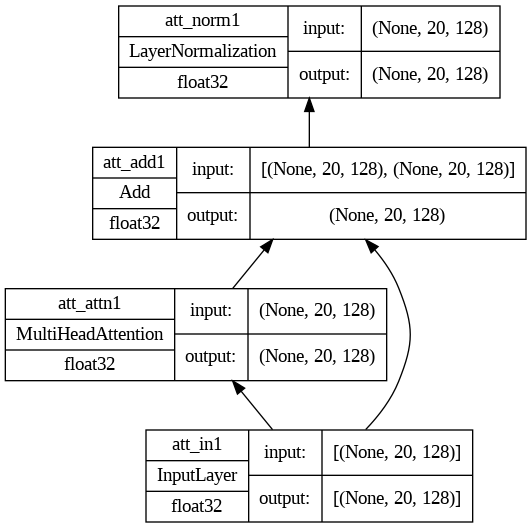

In [ ]:
import tensorflow as tf

def self_attention(input_shape, prefix="att", mask=False, **kwargs):
    """Self-attention layers at Transformer encoder and decoder. Assumes its
    input is the output from positional encoding layer.

    Args:
        prefix (str): The prefix added to the layer names
        masked (bool): whether to use causal mask. Should be False on encoder and
                       True on decoder. When True, a mask will be applied such that
                       each location only has access to the locations before it.
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1", epsilon=1e-7)
    add = tf.keras.layers.Add(name=f"{prefix}_add1")
    # functional API to connect input to output
    attout = attention(query=inputs, value=inputs, key=inputs,
                       use_causal_mask=mask)
    outputs = norm(add([inputs, attout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model

seq_length = 20
key_dim = 128
num_heads = 8

model = self_attention(input_shape=(seq_length, key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "self-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

## Step 6: Cross-attention model of decoder

In the decoder, you have a **cross-attention model** that takes input from the self-attention model as well as the encoder. In this case, the value and key are the output from the encoder whereas the query is the output from the self-attention model. At the high level, it is based on what the encoder understands about the context of the source sentence, and takes the partial sentence at the decoder’s input as the query (which can be empty), to predict how to complete the sentence. This is the only difference from the self-attention model; hence the code is very similar:

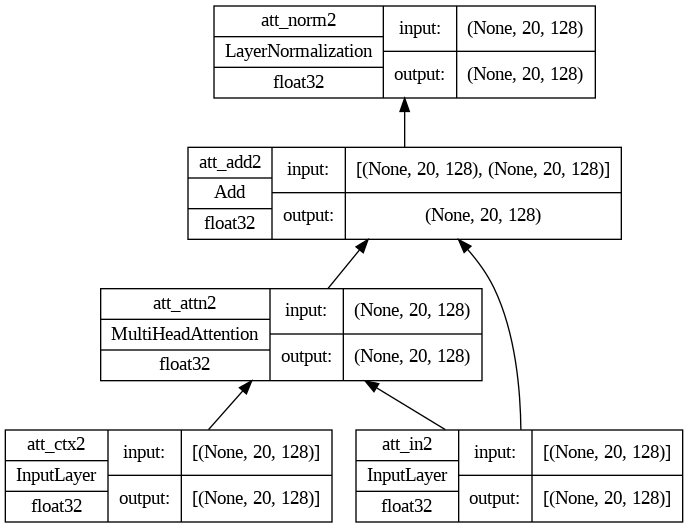

In [ ]:
import tensorflow as tf

def cross_attention(input_shape, context_shape, prefix="att", **kwargs):
    """Cross-attention layers at Transformer decoder. Assumes its
    input is the output from positional encoding layer at decoder
    and context is the final output from encoder.

    Args:
        prefix (str): The prefix added to the layer names
    """
    # create layers
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32',
                                    name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in2")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2", epsilon=1e-7)
    add = tf.keras.layers.Add(name=f"{prefix}_add2")
    # functional API to connect input to output
    attout = attention(query=inputs, value=context, key=context)
    outputs = norm(add([attout, inputs]))
    # create model and return
    model = tf.keras.Model(inputs=[(context, inputs)], outputs=outputs,
                           name=f"{prefix}_cross")
    return model

seq_length = 20
key_dim = 128
num_heads = 8

model = cross_attention(input_shape=(seq_length, key_dim),
                        context_shape=(seq_length, key_dim),
                        num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "cross-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

## Step 7: Feed forward network

Finally, there are feed forward models at the output of both encoder and decoder. Note that the first Dense layer uses ReLU activation and the second has no activation. A dropout layer is then appended for regularization. It is implemented as Dense layers in Keras:

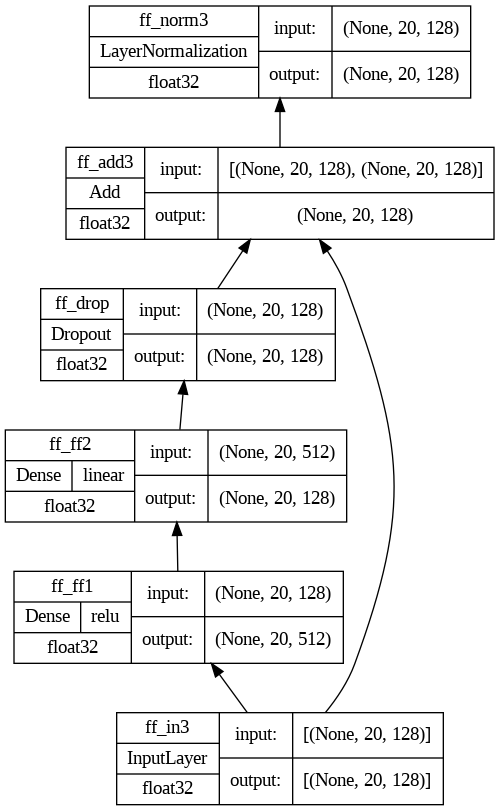

In [ ]:
import tensorflow as tf

def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):
    """Feed-forward layers at Transformer encoder and decoder. Assumes its
    input is the output from an attention layer with add & norm, the output
    is the output of one encoder or decoder block

    Args:
        model_dim (int): Output dimension of the feed-forward layer, which
                         is also the output dimension of the encoder/decoder
                         block
        ff_dim (int): Internal dimension of the feed-forward layer
        dropout (float): Dropout rate
        prefix (str): The prefix added to the layer names
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in3")
    dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
    dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")
    add = tf.keras.layers.Add(name=f"{prefix}_add3")
    # functional API to connect input to output
    ffout = drop(dense2(dense1(inputs)))
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3", epsilon=1e-7)
    outputs = norm(add([inputs, ffout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
    return model

seq_length = 20
key_dim = 128
ff_dim = 512

model = feed_forward(input_shape=(seq_length, key_dim),
                     model_dim=key_dim, ff_dim=ff_dim)
tf.keras.utils.plot_model(model, "feedforward.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

## Step 8: Transformer encoder and decoder

You will see that the encoder is the self-attention submodel connected to the feed forward submodel. The decoder, on the other hand, is a self-attention submodel, a cross-attention submodel, and a feed-forward submodel connected in tandem.

Making an encoder and a decoder is therefore not difficult once you have these submodels as building blocks. Firstly, you have the encoder. It is simple enough that you can build an encoder model using Keras sequential API.

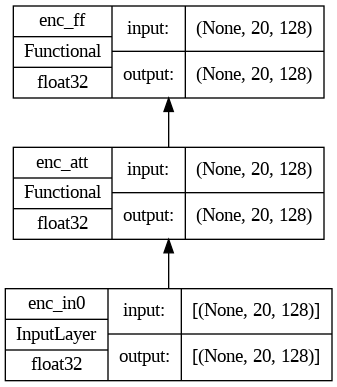

In [ ]:
def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
    """One encoder unit. The input and output are in the same shape so we can
    daisy chain multiple encoder units into one larger encoder"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model


seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "encoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

The decoder is a bit complicated because the cross-attention block takes input from the encoder as well; hence it is a model that takes two input. It is implemented as follows:

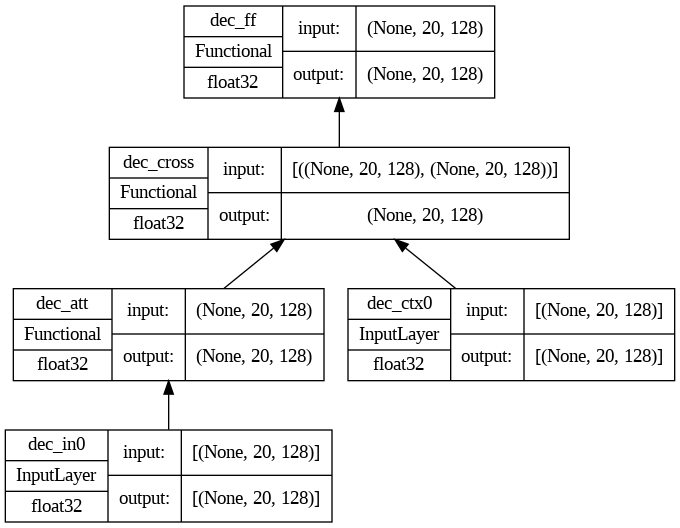

In [ ]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
    """One decoder unit. The input and output are in the same shape so we can
    daisy chain multiple decoder units into one larger decoder. The context
    vector is also assumed to be the same shape for convenience"""
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                    name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True,
                              prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                                 prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model


seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "decoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

Indeed, a Transformer has encoder and decoder parts, and each part is not one but a series of encoders or decoders. It sounds complicated but not if you have the building block submodels to hide the details.

You see the encoder and decoder parts are just a chain of encoder and decoder blocks. Only the output of the final encoder block is used as input to the decoder blocks. Therefore, the complete Transformer model can be built as follows:

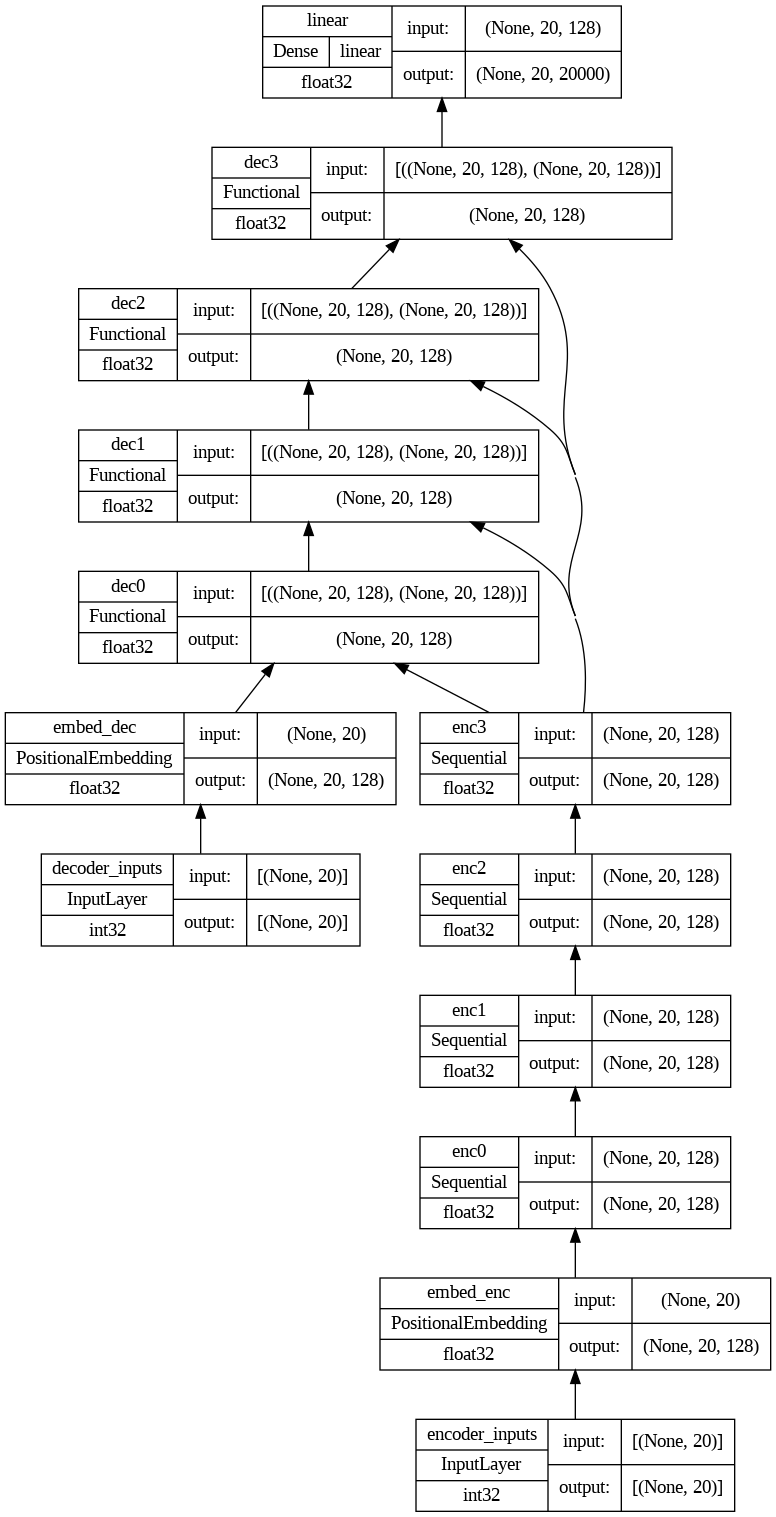

In [ ]:
def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src,
                vocab_size_tgt, dropout=0.1, name="transformer"):
    embed_shape = (seq_len, key_dim)  # output shape of the positional embedding layer
    # set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="decoder_inputs")
    embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")
    encoders = [encoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")
    # build output
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])
    output = final(x2)
    # XXX keep this try-except block
    try:
        del output._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model


seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

The try–except block in the code is to handle a bug in certain versions of TensorFlow that may cause the training error calculated erroneously. The model plotted above would be like the following. Not very simple, but the architecture is still tractable.

### Step 9: Training preparation ###

Before you can train your Transformer, you need to decide how you should train it.

According to the paper Attention Is All You Need, you are using Adam as the optimizer but with a custom learning rate schedule,

$LR = \frac{1}{\sqrt{d_{model}}}min(\frac{1}{\sqrt{n}},\frac{n}{\sqrt{m^3}})$

The learning rate schedule is designed in such a way that it learns slowly at the beginning but accelerates as it learns. This helps because the model is totally random at the beginning, and you cannot even trust the output much. But as you train the model enough, the result should be sufficiently sensible and thus you can learn faster to help convergence.

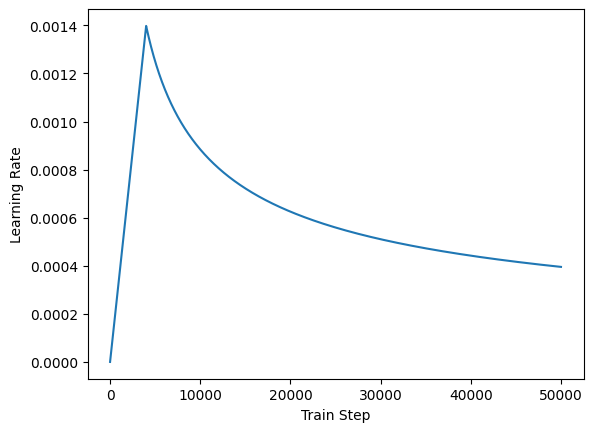

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config

key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

Next, you also need to define the loss metric and accuracy metric for training. This model is special because you need to apply a mask to the output to calculate the loss and accuracy only on the non-padding elements.

In [ ]:
def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

With all these, you can now compile your Keras model as follows:

In [ ]:
vocab_size_en = 10000
vocab_size_fr = 20000
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 embed_enc (PositionalEmbed  (None, 20, 128)              1280000   ['encoder_inputs[0][0]']      
 ding)                                                                                            
                                                                                                  
 enc0 (Sequential)           (None, 20, 128)              659712    ['embed_enc[0][0]']           
                                                                                        

### Step 10: Training the Transformer model ###

Training the Transformer depends on everything you created in all previous steps.

Epoch 1/20
1828/1828 [==============================] - 174s 78ms/step - loss: 5.2272 - masked_accuracy: 0.3035 - val_loss: 3.2598 - val_masked_accuracy: 0.4548
Epoch 2/20
1828/1828 [==============================] - 128s 70ms/step - loss: 2.7419 - masked_accuracy: 0.5376 - val_loss: 2.2865 - val_masked_accuracy: 0.5984
Epoch 3/20
1828/1828 [==============================] - 128s 70ms/step - loss: 2.1099 - masked_accuracy: 0.6292 - val_loss: 1.8565 - val_masked_accuracy: 0.6620
Epoch 4/20
1828/1828 [==============================] - 129s 70ms/step - loss: 1.7512 - masked_accuracy: 0.6839 - val_loss: 1.6308 - val_masked_accuracy: 0.7032
Epoch 5/20
1828/1828 [==============================] - 128s 70ms/step - loss: 1.5785 - masked_accuracy: 0.7147 - val_loss: 1.5175 - val_masked_accuracy: 0.7198
Epoch 6/20
1828/1828 [==============================] - 128s 70ms/step - loss: 1.4574 - masked_accuracy: 0.7356 - val_loss: 1.4597 - val_masked_accuracy: 0.7302
Epoch 7/20
1828/1828 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


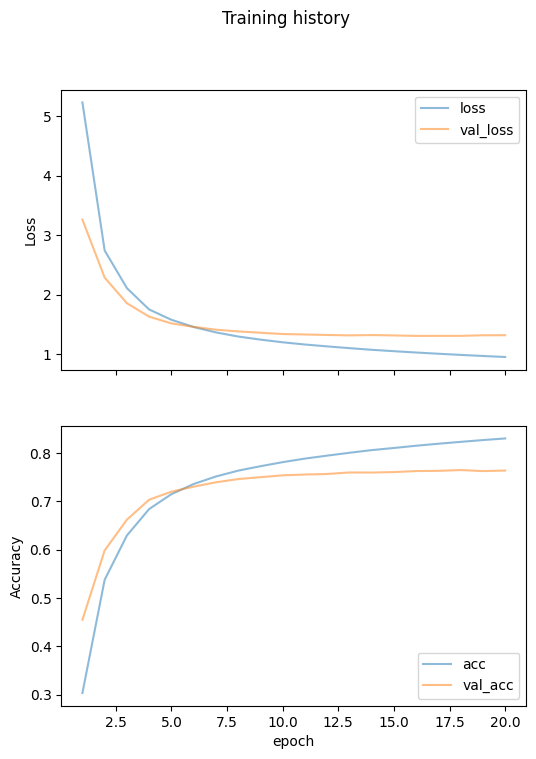

In [ ]:
# Create and train the model
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the trained model
model.save("eng-fra-transformer.h5")

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Training history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

### Step 11: Inference ###

You splitted the original dataset into training, validation, and test sets in the ratio of 70%-15%-15%. You used the training and validation dataset in the training of the Transformer model. You are going to use the test set to see how good your trained model is.

You saved your Transformer model in the previous lesson. Because you have some custom made layers and functions in the model, you need to create a custom object scope to load your saved model.

The Transformer model can give you a token index. You need the vectorizer to look up the word that this index represents. You have to reuse the same vectorizer that you used in creating the dataset to maintain consistency.

Create a loop to scan the generated tokens. In other words, do not use the model to generate the entire translated sentence but consider only the next generated word in the sentence until you see the end sentinel. The first generated word would be the one generated by the start sentinel.

In [ ]:
import random



# Load the trained model
custom_objects = {"PositionalEmbedding": PositionalEmbedding,
                  "CustomSchedule": CustomSchedule,
                  "masked_loss": masked_loss,
                  "masked_accuracy": masked_accuracy}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model("eng-fra-transformer.h5")

# training parameters used
seq_len = 20
vocab_size_en = 10000
vocab_size_fr = 20000

def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(fra_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = fra_vectorizer([" ".join(output_sentence)])
        assert vector.shape == (1, seq_len+1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_len)
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_len, vocab_size_fr)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

test_count = 20
for n in range(test_count):
    english_sentence, french_sentence = random.choice(test_pairs)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {french_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

Test 0:
communicating more to the point and directly would help everyone .
== [start] communiquer de manière plus pertinente et directement aiderait tout le monde . [end]
-> [start] plus se votre point de vue et pas aider tout le monde . [end]

Test 1:
can i meet you tomorrow ?
== [start] puis-je vous rencontrer demain  ?  [end]
-> [start] puis-je te rencontrer demain ? [end]

Test 2:
if you have the time , come along with me .
== [start] si tu as le temps , accompagne-moi . [end]
-> [start] si tu as le temps , je viens avec moi . [end]

Test 3:
i think i have tendonitis .
== [start] je pense que j'ai une tendinite . [end]
-> [start] je pense que j'ai la [UNK] . [end]

Test 4:
we took a cab .
== [start] nous avons pris un taxi . [end]
-> [start] nous avons pris un taxi . [end]

Test 5:
it wasn't mine .
== [start] ce n'était pas le mien . [end]
-> [start] ce n'était pas le mien . [end]

Test 6:
you're the most handsome man i've ever seen .
== [start] vous êtes le plus bel homme que j'ai

The second line of each test is the expected output while the third line is the output from the transformer.

The token [UNK] means “unknown” or out-of-vocabulary, which should appear rarely. Comparing the output, you should see the result is quite accurate. It will not be perfect. For example, they in English can map to ils or elles in French depending on the gender, and the transformer cannot always distinguish that.

You generated the translated sentence word by word, but indeed the transformer outputs the entire sentence in one shot. You can try to modify the program to decode the entire transformer output pred in the for-loop to see how the Transformer gives you a better sentence as you provide more leading words in `dec_tokens`.